In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch

In [2]:
os.chdir('/Users/vincent/Desktop/Capstone Project/Code')

In [3]:
from hp_tuning import HPTuning
from nn import IEEE_MPO
from synthetic import sin_single
from losses import MeanReturns, SharpeRatio, MaximumDrawdown
from data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from online_learning import OnlineLearning

In [4]:
#for replication purposes
torch.manual_seed(4)
np.random.seed(5)

In [5]:
# Dataset creation and loading
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# In this example, we are going to be using a synthetic dataset. Asset returns are going to be
# sine functions where the frequency and phase are randomly selected for each asset. First of
# all let us set all the parameters relevant to data creation.
n_timesteps, n_assets = 1000, 20
lookback, gap, horizon = 36, 0, 6
n_samples = n_timesteps - lookback - horizon - gap + 1

In [6]:
# %%
# Additionally, we will use approximately 80% of the data for training and 20% for testing.
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:766
Test range: 809:958


In [7]:
# Now we can generate the synthetic asset returns of with shape :code:`(n_timesteps, n_assets)`.
returns = np.array([sin_single(n_timesteps,
                               freq=1 / np.random.randint(3, lookback),
                               amplitude=0.05,
                               phase=np.random.randint(0, lookback)
                               ) for _ in range(n_assets)]).T

In [8]:
returns.shape

(1000, 20)

In [9]:
# %%
# We also add some noise.
returns += np.random.normal(scale=0.02, size=returns.shape)

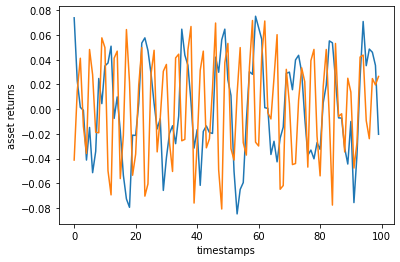

In [10]:
# See below the first 100 timesteps of 2 assets.
plt.plot(returns[:100, [1, 10]])
plt.ylabel('asset returns')
plt.xlabel('timestamps')
plt.show()

In [11]:
# To obtain the feature matrix :code:`X` and the target :code:`y` we apply the rolling window
# strategy.
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(returns[i - lookback: i, :])
    y_list.append(returns[i + gap: i + gap + horizon, :])

X = np.stack(X_list, axis=0)[:, None, ...]
y = np.stack(y_list, axis=0)[:, None, ...]

print('X: {}, y: {}'.format(X.shape, y.shape))

X: (959, 1, 36, 20), y: (959, 1, 6, 20)


In [12]:
# As commonly done in every deep learning application, we want to scale our input features to
# be approximately centered around 0 and have a standard deviation of 1. In :code:`deepdow` we
# can achieve this with the :code:`prepare_standard_scaler` function that computes the mean
# and standard deviation of the input (for each channel). Additionally, we do not want to leak
# any information from our test set and therefore we only compute these statistics over the
# training set.
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [0.00031654], std: [0.04081405]


### Hyperparameter tuning

In [13]:
# We can now construct the :code:`InRAMDataset`. By providing the optional :code:`transform` we
# make sure that when the samples are streamed they are always scaled based on our computed
# (training) statistics. See :ref:`inramdataset` for more details.

dataset = InRAMDataset(X, y, transform=Scale(means, stds), asset_names=np.arange(n_assets))

In [14]:
loss = MaximumDrawdown() + 2 * MeanReturns() + SharpeRatio()

In [14]:
tuner = HPTuning(dataset, indices_train, loss, n_splits=2, n_trials=50)

In [15]:
best_params = tuner()

[I 2021-12-02 20:10:57,472] A new study created in memory with name: no-name-a66c59d5-db6d-496c-9e81-bc1e48c4dd76
Epoch 0: 100%|█| 12/12 [00:19<00:00,  1.60s/it, loss=-0.31931, test_loss=-0.9048
Epoch 1: 100%|█| 12/12 [00:19<00:00,  1.64s/it, loss=-1.41541, test_loss=-1.9989
Epoch 2: 100%|█| 12/12 [00:17<00:00,  1.44s/it, loss=-2.04508, test_loss=-2.2935
Epoch 3: 100%|█| 12/12 [00:17<00:00,  1.45s/it, loss=-2.38924, test_loss=-2.0703
Epoch 4: 100%|█| 12/12 [00:16<00:00,  1.38s/it, loss=-2.56709, test_loss=-2.1448
Epoch 0: 100%|█| 12/12 [00:18<00:00,  1.54s/it, loss=-0.81034, test_loss=-1.7593
Epoch 1: 100%|█| 12/12 [00:20<00:00,  1.70s/it, loss=-2.23914, test_loss=-2.4254
Epoch 2: 100%|█| 12/12 [00:18<00:00,  1.58s/it, loss=-2.61716, test_loss=-2.5400
Epoch 3: 100%|█| 12/12 [00:18<00:00,  1.54s/it, loss=-2.92565, test_loss=-2.5375
Epoch 4: 100%|█| 12/12 [00:17<00:00,  1.49s/it, loss=-3.01500, test_loss=-2.5547
[I 2021-12-02 20:14:17,583] Trial 0 finished with value: -2.4676766395568848

In [16]:
best_params

{'lr': 0.00678479848433982,
 'hidden_channels': 14,
 'kernel_size': 7,
 'risk_aversion': 8.795701580422564,
 'transaction_cost': 0.001519613147049753,
 'min_weight': 0.0023034598171540856,
 'max_weight': 0.5952437476743871}

### Training the model using the entire training set with best hyperparameters

In [16]:
model = IEEE_MPO(hidden_channels=best_params['hidden_channels'],
                 kernel_size=best_params['kernel_size'],
                 risk_aversion=best_params['risk_aversion'],
                 transaction_cost=best_params['transaction_cost'],
                 min_weight = best_params['min_weight'],
                 max_weight = best_params['max_weight']
                 )

In [17]:
optimizer = torch.optim.Adam(model.parameters(), best_params['lr'])

In [18]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

In [19]:
PVM = pd.DataFrame(1/n_assets, index=np.arange(len(indices_train) + 1), columns=np.arange(n_assets))

In [20]:
from experiments import Run

In [21]:
run = Run(model,
          loss,
          dataloader_train,
          PVM)

In [22]:
history = run.launch(30)

Epoch 29: 100%|████████████████| 24/24 [02:47<00:00,  6.97s/it, loss=-2.13389, ]


### Online Learning and test set evaluation using rolling cross validation

In [23]:
OL = OnlineLearning(model, dataset, indices_test, optimizer, loss)

In [24]:
weights = OL()

Epoch 19: 100%|██████████████████| 2/2 [00:00<00:00,  7.07it/s, loss=-2.86740, ]


In [31]:
weights.columns = [str(i) for i in range(20)]
weights.to_parquet('synthetic_weights.prq')